In [1]:
import saxtal_functions as sax
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from tqdm import tqdm

In [2]:
filename = 'test_data/test_lattices/000022735715047590394_SFO2_118_0019_patch_aligned_doseweighted_bin_2.mrc'
filename_out = 'test_data/test_lattices/000022735715047590394_SFO2_118_0019_patch_aligned_doseweighted_bin_2_masked.mrc'
threshold_method='sd' 
pixel_size = 1.048
verbose=True
show_plots=True
threads=16
sigma=15 
num_sd=3.0
num_sd_secondpass=2.0
x_window_percent=(0, 0.7)
y_window_percent=(0, 0.995)
miller_index_buffer=2
box_radius=10
min_lattice_size=5
mask_hotpixels=False
mask_radius=5
replace_distance_percent=0.05
return_spots=False

In [ ]:
# To test multiple lattices, use:

# filename = 'test_data/test_lattices/000022735715047590394_SFO2_118_0019_patch_aligned_doseweighted_bin_2.mrc'
# filename_out = 'test_data/test_lattices/000022735715047590394_SFO2_118_0019_patch_aligned_doseweighted_bin_2_masked.mrc'
# threshold_method='sd' 
# pixel_size = 1.048
# verbose=True
# show_plots=True
# threads=16
# sigma=15 
# num_sd=3.0
# num_sd_secondpass=2.0
# x_window_percent=(0, 0.7)
# y_window_percent=(0, 0.995)
# miller_index_buffer=2
# box_radius=10
# min_lattice_size=5
# mask_hotpixels=False
# mask_radius=5
# replace_distance_percent=0.05
# return_spots=False

scipy_fft(): FFT performed in 87.35 milliseconds.
Number of first-pass spots found: 129


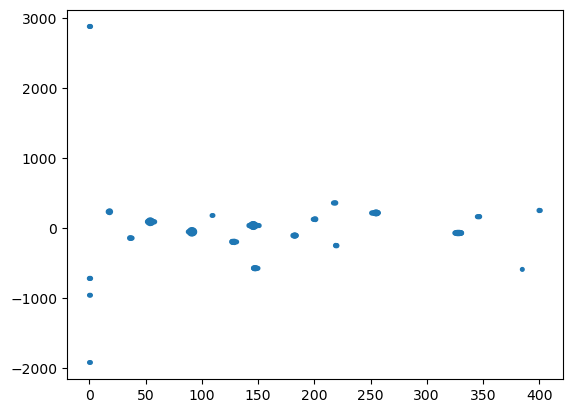

Starting basis: [[ 35 -54]
 [146  92]]
Starting basis size: 33921
Running basis shortening...
The angle between the basis vectors is: 43.89197108205816
[ 35 146] is larger than [-54  92]
The updated basis vectors are [89 54][-54  92]
This run resulted in a basis smaller than the last: 22217
The updated basis vectors are: [[ 89 -54]
 [ 54  92]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 89.16415185364842
[-54  92] is larger than [89 54]
The updated basis vectors are [-143   38][89 54]
This run resulted in a basis larger than the last: 32730
Terminating loop.
------------------------------------


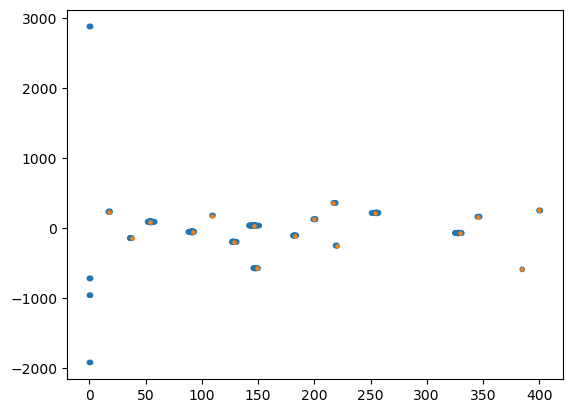

Starting basis: [[ 89 -54]
 [ 54  92]]
Refined_basis: [[ 89.55082367 -53.77754728]
 [ 54.30372178  91.48663819]]


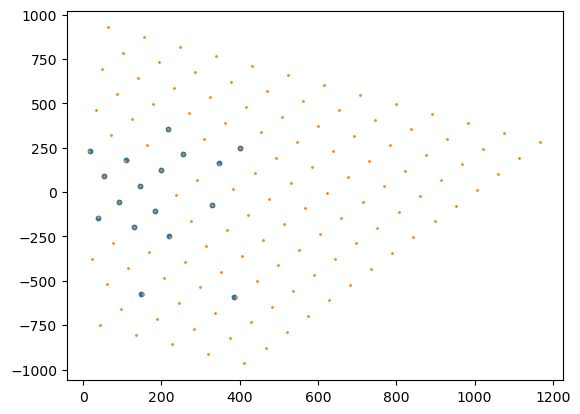

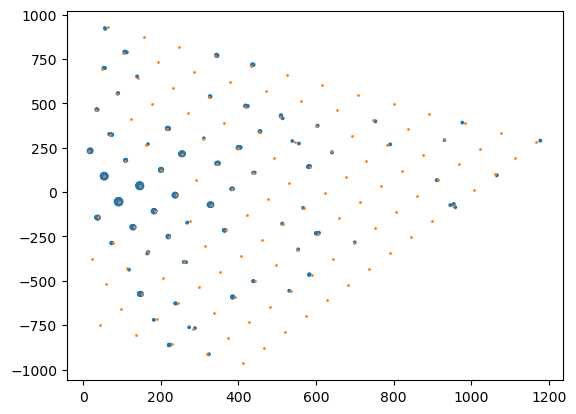

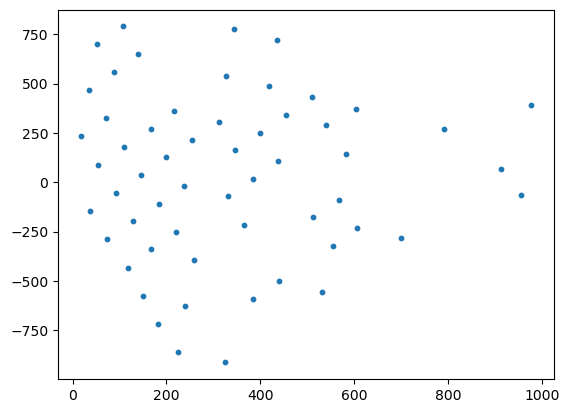

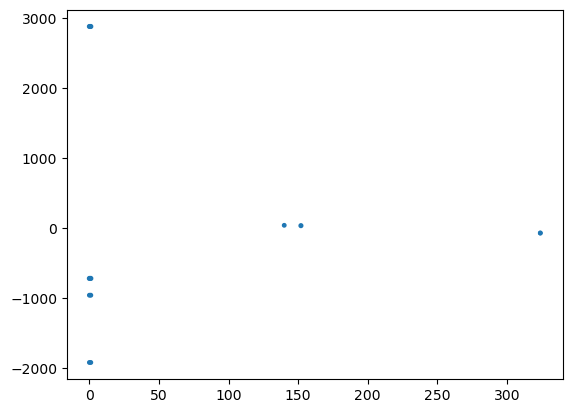

Starting basis: [[-720 2880]
 [   0    1]]
Starting basis size: 8812801
Running basis shortening...
The angle between the basis vectors is: 0.019894367069059806
[2880    1] is larger than [720   0]
The updated basis vectors are [2160    1][720   0]
This run resulted in a basis smaller than the last: 5184001
The updated basis vectors are: [[2160 -720]
 [   1    0]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 0.026525821970813417
[2160    1] is larger than [720   0]
The updated basis vectors are [1440    1][720   0]
This run resulted in a basis smaller than the last: 2592001
The updated basis vectors are: [[1440 -720]
 [   1    0]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 0.03978872937915263
[1440    1] is larger than [720   0]
The updated basis vectors are [720   1][720   0]
This run resulted in a basis smaller than the last: 1036801
The updated basis vectors are:

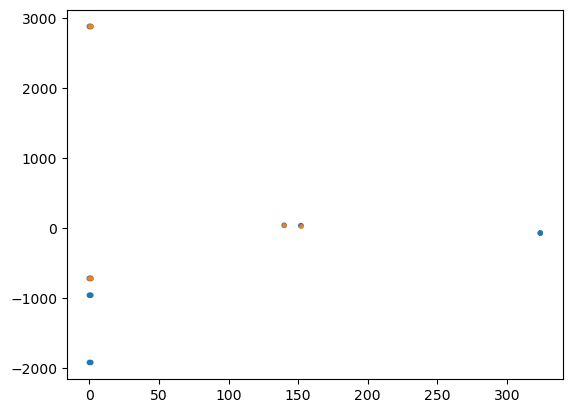

Starting basis: [[   0 -720]
 [   1    0]]
Refined_basis: [[ 2.48865871e-01 -7.19978041e+02]
 [ 1.00000000e+00 -6.93889390e-18]]
Lattice unit cell max dimension is 5857.81 Angstrom. Terminating function.
[57.64 56.88] 5.73
scipy_ifft(): iFFT performed in 67.61 milliseconds.
Export complete!
test_data/test_lattices/000022735715047590394_SFO2_118_0019_patch_aligned_doseweighted_bin_2.mrc masked successfully!


In [3]:
sax.mask_image(filename,
               filename_out,
               threshold_method,
               pixel_size,
               verbose = verbose,
               show_plots = show_plots,
               threads = threads,
               sigma = sigma,
               num_sd = num_sd,
               num_sd_secondpass = num_sd_secondpass,
               x_window_percent = x_window_percent,
               y_window_percent = y_window_percent,
               miller_index_buffer = miller_index_buffer,
               box_radius = box_radius,
               min_lattice_size = min_lattice_size,
               mask_hotpixels = mask_hotpixels,
               mask_radius= mask_radius,
               replace_distance_percent = replace_distance_percent,
               return_spots = return_spots)

In [ ]:
# Import the image
image, header = sax.import_mrc(filename)

# Perform an FFT of the image
padded_fft = sax.scipy_fft(image, verbose, threads)

# Subtract the FFT from a Gaussian-smoothed FFT
log_diff_spectrum, smoothed_spectrum = sax.generate_diff_spectrum(padded_fft, sigma)

# Find diffraction spots
if threshold_method == "quantile":
    diffraction_indices, diffraction_amplitudes = find_diffraction_spots_quantile(log_diff_spectrum, quantile, x_window_percent, y_window_percent)
if threshold_method == "sd":
    diffraction_indices, diffraction_amplitudes = sax.find_diffraction_spots_sd(log_diff_spectrum, num_sd, x_window_percent, y_window_percent)
else:
    print("No thresholding method specified. Please specify a method using the threshold_method parameter.")
    

# Return some info if function is verbose
if verbose:
    print("Number of first-pass spots found: " + str(diffraction_indices.shape[0]))

# Start while ----------------------------

# Look for the lattice
combined_nonredundant_lattice, unit_cell_dimensions, highest_resolution = sax.find_lattice(diffraction_indices,
                                                                                       diffraction_amplitudes, 
                                                                                       log_diff_spectrum, 
                                                                                       pixel_size, 
                                                                                       show_plots=True, 
                                                                                       verbose=True, 
                                                                                       num_sd_secondpass=2, 
                                                                                       miller_index_buffer=2, 
                                                                                       box_radius=10, 
                                                                                       min_lattice_size=5)


# Filter out the hot pixels - leave off, depreciated
if mask_hotpixels:
    if verbose: print("Removing hot pixels...")
    combined_nonredundant_lattice = combined_nonredundant_lattice[remove_hotpixels(combined_nonredundant_lattice, verbose)]
    if verbose: print(str(num_spots - combined_nonredundant_lattice.shape[0]) + " hot pixels removed.")


In [ ]:
for indices in np.transpose(combined_nonredundant_lattice):
    print(indices)

In [ ]:
masked_fft = replace_diffraction_spots(padded_fft, combined_nonredundant_lattice, replace_distance_percent)

In [ ]:
image, header = sax.import_mrc(filename)
padded_fft = sax.scipy_fft(image, verbose, 16)
log_diff_spectrum, smoothed_spectrum = sax.generate_diff_spectrum(padded_fft, sigma)

In [ ]:
diffraction_indices, diffraction_amplitudes = sax.find_diffraction_spots_sd(log_diff_spectrum, num_sd, x_window_percent, y_window_percent)

In [ ]:
combined_nonredundant_lattice, unit_cell_dimensions, highest_resolution = sax.find_lattice(diffraction_indices, 
                                                                                           diffraction_amplitudes, 
                                                                                           log_diff_spectrum,
                                                                                           pixel_size = 1.048,
                                                                                           show_plots=True,
                                                                                           verbose=True, 
                                                                                           num_sd_secondpass=2,
                                                                                           miller_index_buffer=2, 
                                                                                           box_radius=10,
                                                                                           min_lattice_size=5)

print(unit_cell_dimensions, highest_resolution)

In [ ]:
mask_indices_array = sax.generate_lattice_mask_indices(combined_nonredundant_lattice)

In [ ]:
# Pass these values to replace_diffraction_spots

masked_fft = sax.replace_diffraction_spots(padded_fft, mask_indices_array)

In [ ]:
# From here, calculate a new log_diff_spectrum and rerun pipeline
# If the lattice has more than 5 points...do something. Remove it?

In [ ]:
log_diff_spectrum, smoothed_spectrum = sax.generate_diff_spectrum(masked_fft, sigma)

In [ ]:
diffraction_indices, diffraction_amplitudes = sax.find_diffraction_spots_sd(log_diff_spectrum, num_sd, x_window_percent, y_window_percent)

In [ ]:
combined_nonredundant_lattice, unit_cell_dimensions, highest_resolution = sax.find_lattice(diffraction_indices, 
                                                                                           diffraction_amplitudes, 
                                                                                           log_diff_spectrum,
                                                                                           pixel_size = 1.048,
                                                                                           show_plots=True,
                                                                                           verbose=True, 
                                                                                           num_sd_secondpass=2, 
                                                                                           miller_index_buffer=2, 
                                                                                           box_radius=10,
                                                                                           min_lattice_size=5)

print(combined_nonredundant_lattice, unit_cell_dimensions, highest_resolution)